# Assignment Name: Predictive Spatial Analysis

Student Name: Sneha Dinesh Porwal

Student Id: 3739281

Date: 07 Feb, 2024

## Description:

This assignment involves a comprehensive analysis of crime data within the city of Toronto, utilizing datasets provided by the Toronto Public Service Public Safety Data Portal. The analysis will focus on identifying spatial patterns of crimes through point pattern analysis and density mapping. Additionally, the assignment will delve into the calculation of global Moran's I to determine the likelihood of these patterns arising by chance, considering spatial autocorrelation.

## Objective:

The primary objective is to discern whether crimes in Toronto are geographically clustered or randomly distributed and to understand central tendencies within local crime density. Furthermore, the assignment aims to examine the influence of various socio-demographic factors such as age, employment, and income on crime patterns, seeking to uncover any underlying correlations or trends that may explain the spatial distribution of criminal activities across different neighborhoods. The task includes direct API access for data retrieval, spatial analysis using appropriate methodologies, and the integration of external datasets to enrich the analysis.

### Data Extraction and Cleaning

#### Data Source
The data for this assignment is sourced from the Toronto Police Service Public Safety Data Portal. Specifically, we're focusing on robbery crimes from January 1, 2021, to June 30, 2021, which can be explored via this https://data.torontopolice.on.ca/datasets/d0e1e98de5f945faa2fe635dee3f4062_0/explore?location=17.912759%2C-39.813030%2C3.00

#### Retrieving the Data

In [1]:
import requests
import pandas as pd

# Define the API endpoint and parameters for the request
url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/Robbery_Open_Data/FeatureServer/0/query"
params = {
    "where": "REPORT_DATE BETWEEN timestamp '2021-01-01' AND timestamp '2021-07-01'",
    "outFields": "*",
    "f": "json",
}

# Make the GET request to the API endpoint
response = requests.get(url, params=params)

# Validate the response
if response.status_code == 200:
    data = response.json()
    print("Data loaded successfully.")
else:
    print("Failed to retrieve data, status code:", response.status_code)

Data loaded successfully.


#### Preparing the Data

After successfully retrieving the data, the next step is to convert it into a pandas DataFrame and filter it down to the relevant columns.

In [2]:
# Normalize the JSON response into a flat table
records = [feature["attributes"] for feature in data["features"]]
df = pd.DataFrame(records)

# Display the DataFrame to verify its structure before filtering
print("DataFrame before filtering columns:")
df

DataFrame before filtering columns:


,OBJECTID,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,REPORT_DOW,REPORT_HOUR,...,UCR_CODE,UCR_EXT,OFFENCE,MCI_CATEGORY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84
0,25535,GO-20212771,1609477200000,1609477200000,2021,January,1,1,Friday,15,...,1610,200,Robbery - Mugging,Robbery,154,Oakdale-Beverley Heights,26,Downsview-Roding-CFB (26),-79.508638,43.720978
1,25536,GO-2021613,1609477200000,1609477200000,2021,January,1,1,Friday,2,...,1610,220,Robbery - Other,Robbery,12,Markland Wood,12,Markland Wood (12),-79.584348,43.639208
2,25537,GO-20211618,1609477200000,1609477200000,2021,January,1,1,Friday,8,...,1610,220,Robbery - Other,Robbery,170,Yonge-Bay Corridor,76,Bay Street Corridor (76),-79.382386,43.650276
3,25538,GO-20212447840,1609477200000,1609304400000,2021,January,1,1,Friday,12,...,1610,220,Robbery - Other,Robbery,95,Annex,95,Annex (95),-79.403809,43.666660
4,25539,GO-2021322,1609477200000,1609477200000,2021,January,1,1,Friday,0,...,1610,200,Robbery - Mugging,Robbery,NSA,NSA,NSA,NSA,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,26492,GO-20211229573,1625025600000,1625025600000,2021,June,30,181,Wednesday,21,...,1610,200,Robbery - Mugging,Robbery,15,Kingsway South,9,Edenbridge-Humber Valley (9),-79.516030,43.657745
958,26493,GO-20211228935,1625025600000,1625025600000,2021,June,30,181,Wednesday,21,...,1610,210,Robbery - Business,Robbery,12,Markland Wood,12,Markland Wood (12),-79.561282,43.634351
959,26494,GO-20211222501,1625025600000,1624939200000,2021,June,30,181,Wednesday,1,...,1610,180,Robbery - Swarming,Robbery,30,Brookhaven-Amesbury,30,Brookhaven-Amesbury (30),-79.482424,43.707535
960,26495,GO-20211222782,1625025600000,1625025600000,2021,June,30,181,Wednesday,0,...,1610,100,Robbery With Weapon,Robbery,84,Little Portugal,84,Little Portugal (84),-79.436114,43.649349


#### Filtering and Cleaning

We now filter out unnecessary columns, handle missing values, ensure that dates are in the correct format, and prepare the geometric data for spatial analysis.

In [3]:
import geopandas as gpd
from shapely.geometry import Point

# List of columns of interest that we want to keep
columns_of_interest = [
    'LONG_WGS84', 'LAT_WGS84', 'REPORT_DATE', 'OCC_DATE',
    'REPORT_YEAR', 'REPORT_MONTH', 'REPORT_DAY', 'REPORT_HOUR',
    'OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_HOUR',
    'DIVISION', 'LOCATION_TYPE', 'PREMISES_TYPE', 'OFFENCE',
    'MCI_CATEGORY', 'NEIGHBOURHOOD_158'
]

# Filter the DataFrame
df_crimes = df[columns_of_interest].copy()

# Convert the timestamps from UNIX to human-readable dates
df_crimes['REPORT_DATE'] = pd.to_datetime(df_crimes['REPORT_DATE'] / 1000, unit='s')
df_crimes['OCC_DATE'] = pd.to_datetime(df_crimes['OCC_DATE'] / 1000, unit='s')

# Create a GeoDataFrame for spatial analysis
gdf_crimes = gpd.GeoDataFrame(
    df_crimes,
    geometry=gpd.points_from_xy(df_crimes['LONG_WGS84'], df_crimes['LAT_WGS84'])
)

# Display the prepared GeoDataFrame
print("Data filtered and prepared for analysis.")
gdf_crimes

Data filtered and prepared for analysis.


,LONG_WGS84,LAT_WGS84,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_HOUR,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_HOUR,DIVISION,LOCATION_TYPE,PREMISES_TYPE,OFFENCE,MCI_CATEGORY,NEIGHBOURHOOD_158,geometry
0,-79.508638,43.720978,2021-01-01 05:00:00,2021-01-01 05:00:00,2021,January,1,15,2021,January,1,13,D31,Other Commercial / Corporate Places (For Profi...,Commercial,Robbery - Mugging,Robbery,Oakdale-Beverley Heights,POINT (-79.50864 43.72098)
1,-79.584348,43.639208,2021-01-01 05:00:00,2021-01-01 05:00:00,2021,January,1,2,2021,January,1,1,D22,"Gas Station (Self, Full, Attached Convenience)",Commercial,Robbery - Other,Robbery,Markland Wood,POINT (-79.58435 43.63921)
2,-79.382386,43.650276,2021-01-01 05:00:00,2021-01-01 05:00:00,2021,January,1,8,2021,January,1,7,D52,"Apartment (Rooming House, Condo)",Apartment,Robbery - Other,Robbery,Yonge-Bay Corridor,POINT (-79.38239 43.65028)
3,-79.403809,43.666660,2021-01-01 05:00:00,2020-12-30 05:00:00,2021,January,1,12,2020,December,30,11,D53,Ttc Subway Station,Transit,Robbery - Other,Robbery,Annex,POINT (-79.40381 43.66666)
4,0.000000,0.000000,2021-01-01 05:00:00,2021-01-01 05:00:00,2021,January,1,0,2021,January,1,0,NSA,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Robbery - Mugging,Robbery,NSA,POINT (0.00000 0.00000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,-79.516030,43.657745,2021-06-30 04:00:00,2021-06-30 04:00:00,2021,June,30,21,2021,June,30,20,D22,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Robbery - Mugging,Robbery,Kingsway South,POINT (-79.51603 43.65774)
958,-79.561282,43.634351,2021-06-30 04:00:00,2021-06-30 04:00:00,2021,June,30,21,2021,June,30,19,D22,Pharmacy,Other,Robbery - Business,Robbery,Markland Wood,POINT (-79.56128 43.63435)
959,-79.482424,43.707535,2021-06-30 04:00:00,2021-06-29 04:00:00,2021,June,30,1,2021,June,29,23,D12,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,Robbery - Swarming,Robbery,Brookhaven-Amesbury,POINT (-79.48242 43.70754)
960,-79.436114,43.649349,2021-06-30 04:00:00,2021-06-30 04:00:00,2021,June,30,0,2021,June,30,0,D11,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Robbery With Weapon,Robbery,Little Portugal,POINT (-79.43611 43.64935)


#### Removing Inaccurate Records

Finally, we'll remove records with missing or zero coordinates, which cannot be used in spatial analysis.

In [4]:
# Remove records with zero longitudes and latitudes as they are likely to be inaccurate
gdf_crimes = gdf_crimes[(gdf_crimes['LONG_WGS84'] != 0) & (gdf_crimes['LAT_WGS84'] != 0)]

# Display the records to confirm the changes
gdf_crimes

,LONG_WGS84,LAT_WGS84,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_HOUR,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_HOUR,DIVISION,LOCATION_TYPE,PREMISES_TYPE,OFFENCE,MCI_CATEGORY,NEIGHBOURHOOD_158,geometry
0,-79.508638,43.720978,2021-01-01 05:00:00,2021-01-01 05:00:00,2021,January,1,15,2021,January,1,13,D31,Other Commercial / Corporate Places (For Profi...,Commercial,Robbery - Mugging,Robbery,Oakdale-Beverley Heights,POINT (-79.50864 43.72098)
1,-79.584348,43.639208,2021-01-01 05:00:00,2021-01-01 05:00:00,2021,January,1,2,2021,January,1,1,D22,"Gas Station (Self, Full, Attached Convenience)",Commercial,Robbery - Other,Robbery,Markland Wood,POINT (-79.58435 43.63921)
2,-79.382386,43.650276,2021-01-01 05:00:00,2021-01-01 05:00:00,2021,January,1,8,2021,January,1,7,D52,"Apartment (Rooming House, Condo)",Apartment,Robbery - Other,Robbery,Yonge-Bay Corridor,POINT (-79.38239 43.65028)
3,-79.403809,43.666660,2021-01-01 05:00:00,2020-12-30 05:00:00,2021,January,1,12,2020,December,30,11,D53,Ttc Subway Station,Transit,Robbery - Other,Robbery,Annex,POINT (-79.40381 43.66666)
5,-79.412893,43.769269,2021-01-02 05:00:00,2021-01-02 05:00:00,2021,January,2,18,2021,January,2,18,D32,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Robbery - Swarming,Robbery,Yonge-Doris,POINT (-79.41289 43.76927)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,-79.516030,43.657745,2021-06-30 04:00:00,2021-06-30 04:00:00,2021,June,30,21,2021,June,30,20,D22,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Robbery - Mugging,Robbery,Kingsway South,POINT (-79.51603 43.65774)
958,-79.561282,43.634351,2021-06-30 04:00:00,2021-06-30 04:00:00,2021,June,30,21,2021,June,30,19,D22,Pharmacy,Other,Robbery - Business,Robbery,Markland Wood,POINT (-79.56128 43.63435)
959,-79.482424,43.707535,2021-06-30 04:00:00,2021-06-29 04:00:00,2021,June,30,1,2021,June,29,23,D12,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,Robbery - Swarming,Robbery,Brookhaven-Amesbury,POINT (-79.48242 43.70754)
960,-79.436114,43.649349,2021-06-30 04:00:00,2021-06-30 04:00:00,2021,June,30,0,2021,June,30,0,D11,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Robbery With Weapon,Robbery,Little Portugal,POINT (-79.43611 43.64935)


## PART A

### 1. Are the crimes clustered? Is there Central Tendency? Create a density map showing the local density (quadrat or kernel method may be used) and describe the results (< 100 words).

##### Objective

To determine if the crimes are clustered and if there is a central tendency in the distribution of robbery incidents in Toronto.

##### Kernel Density Estimation (KDE)

The following code performs a KDE to visualize the local density of crimes. We then identify the central tendency by finding the peak of the crime density.

In [5]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Assuming lat_long contains latitude and longitude data as a 2D array
lat_long = gdf_crimes[['LAT_WGS84', 'LONG_WGS84']].values

# Perform the kernel density estimate (KDE)
kde = gaussian_kde(lat_long.T)

# Create a grid over which to evaluate the KDE
xmin, ymin = lat_long.min(axis=0)
xmax, ymax = lat_long.max(axis=0)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Evaluate the KDE function over the grid
f = np.reshape(kde(positions).T, xx.shape)

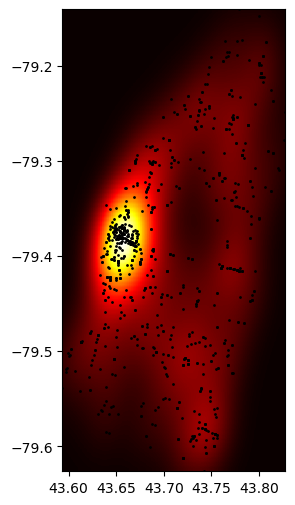

In [6]:
# Plot the KDE as a heatmap
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Display the heatmap of the KDE results
ax.imshow(np.rot90(f), cmap='hot', extent=[xmin, xmax, ymin, ymax])

# Overlay the crime incidents as black dots
ax.plot(lat_long[:, 0], lat_long[:, 1], 'k.', markersize=2)

# Set the axis limits to match the data range
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Display the plot
plt.show()

##### Identifying the Central Tendency

In [7]:
from scipy.spatial import distance

# Find the location of the highest density
max_density_index = np.argmax(f)
max_density_location = positions[:, max_density_index]

# Convert the index to coordinates
central_longitude, central_latitude = max_density_location

# Calculate centroids for each neighborhood for which we use 'NEIGHBOURHOOD_158' column for grouping
neighborhood_centroids = gdf_crimes.groupby('NEIGHBOURHOOD_158').apply(
    lambda g: (g['LONG_WGS84'].mean(), g['LAT_WGS84'].mean())
).reset_index().rename(columns={0: 'centroid'})

# Calculate the Euclidean distance from each neighborhood centroid to the point of highest density
neighborhood_centroids['distance_to_high_density'] = neighborhood_centroids['centroid'].apply(
    lambda x: distance.euclidean(x, (central_latitude, central_longitude))
)

# Identify the closest neighborhood to the highest density point
closest_neighborhood = neighborhood_centroids.loc[neighborhood_centroids['distance_to_high_density'].idxmin()]

# Print the name and coordinates of the closest neighborhood
print(f"The neighborhood with the highest crime density is {closest_neighborhood['NEIGHBOURHOOD_158']}, "
      f"located at latitude {round(closest_neighborhood['centroid'][1], 2)} "
      f"and longitude {round(closest_neighborhood['centroid'][0], 2)}.")

The neighborhood with the highest crime density is Downtown Yonge East, located at latitude 43.66 and longitude -79.38.


Based on the kernel density estimation (KDE) and the corresponding heatmap visualization, we have assessed the spatial distribution of crime incidents.

##### Are the crimes clustered?

Yes, the KDE heatmap reveals that crimes are indeed clustered. The highest intensity areas on the heatmap correspond to regions with a greater number of incidents, indicating clusters of crime in those specific neighborhoods.

##### Is there Central Tendency?

The heatmap indicates a central tendency of crimes around the central coordinates (latitude 43.66, longitude -79.38), pointing to a central tendency within the Downtown Yonge East neighborhood. The brightest spot on the heatmap, representing the highest density of crime, is situated in this specific area, suggesting that crimes are predominantly concentrated around this central location. This finding identifies Downtown Yonge East as the neighborhood experiencing the most significant concentration of criminal activity within the analyzed data set.

##### Describing the Results (< 100 words):

The KDE analysis and heatmap visualization effectively highlight areas of concentrated crime, with the Downtown Yonge East neighborhood emerging as a focal point of criminal activity. This neighborhood, marked by the heatmap's brightest region, signifies a pronounced central tendency and clustering of crimes. The distinct contrast between this hotspot and the surrounding cooler areas on the map accentuates the uneven distribution of crime across the city. The identification of Downtown Yonge East as the principal crime hotspot underscores the critical need for targeted law enforcement and community intervention initiatives within and around this central urban area.

### 2. Are there spatial outliers or trends in the data you’ve selected? Discuss (include any tests run, figures, and maps generated) (200 - 400 words).

##### Objective

To identify spatial outliers or trends in the robbery crime data of Toronto using Local Moran's I statistics.


##### Validating Geometries

Before calculating Moran's I, we ensure that all geometries are valid to prevent errors in the analysis.

In [8]:
gdf_crimes = gdf_crimes[gdf_crimes.is_valid]
print(f"Valid geometries: {gdf_crimes.shape[0]}")

Valid geometries: 940


###### Creating Spatial Weights

Spatial weights are crucial for identifying the relationship between different locations. A K-nearest neighbor (KNN) approach will be used to define spatial context.

In [9]:
from libpysal.weights import KNN

# 'gdf_crimes' is our GeoDataFrame with the point geometries
k = 10  # Number of nearest neighbors
w = KNN.from_dataframe(gdf_crimes, k=k)
w.transform = 'R'

##### Calculating Local Moran's I

Local Moran's I helps identify clusters of similar values and spatial outliers.

In [10]:
from esda.moran import Moran_Local

# If gdf_crimes is derived from another DataFrame and might be a view, ensure it's a standalone copy
gdf_crimes = gdf_crimes.copy()

# Calculate 'crime_counts' based on the combination of 'LAT_WGS84' and 'LONG_WGS84'
gdf_crimes['crime_counts'] = gdf_crimes.groupby(['LAT_WGS84', 'LONG_WGS84'])['LAT_WGS84'].transform('count')

# Prepare the data for Moran's I calculation
y = gdf_crimes['crime_counts'].values

# Assuming 'w' is previously defined spatial weights
moran_loc = Moran_Local(y, w)

# Add significant and quadrant information to the GeoDataFrame, directly modifying the original DataFrame
gdf_crimes['significant'] = moran_loc.p_sim < 0.05
gdf_crimes['quadrant'] = moran_loc.q

##### Visualization

Visualizing significant clusters and outliers helps to identify and interpret spatial patterns.

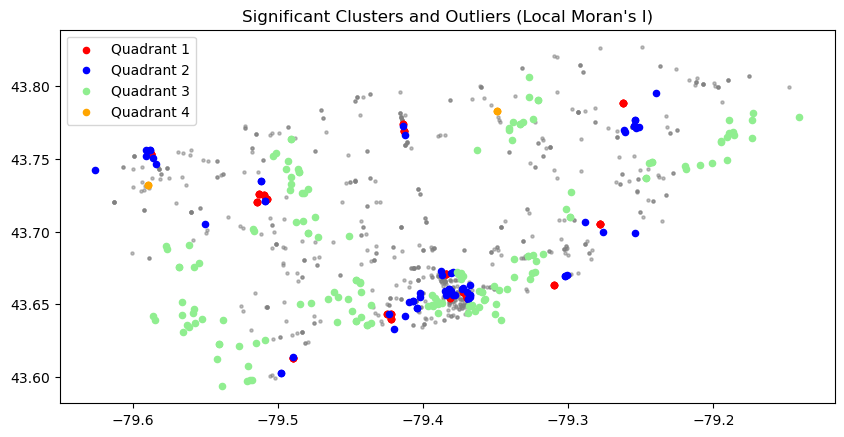

In [11]:
import matplotlib.pyplot as plt

# Define colors for the Moran's I quadrants
colors = {1: 'red', 2: 'blue', 3: 'lightgreen', 4: 'orange'}

# Plot significant clusters
fig, ax = plt.subplots(figsize=(10, 10))
gdf_crimes[gdf_crimes['significant'] == False].plot(ax=ax, color='grey', markersize=5, alpha=0.5)
for quadrant, color in colors.items():
    gdf_crimes[(gdf_crimes['quadrant'] == quadrant) & (gdf_crimes['significant'])].plot(ax=ax, markersize=20, color=color, label=f'Quadrant {quadrant}')
plt.legend()
plt.title('Significant Clusters and Outliers (Local Moran\'s I)')
plt.show()

#### Describing the Results (200-400 words):

The above plot displays the results of a Local Moran's I analysis, which identifies clusters of similar values and spatial outliers in Toronto's robbery crime data. This analysis is instrumental in uncovering patterns of spatial autocorrelation, where crime incidents do not occur randomly over space but are clustered in certain areas.

From the visualization, we observe several distinct clusters indicated by colored points, each representing a quadrant of the Moran's I statistic:

- **Quadrant 1 (red points):** High-high clusters, where high crime rates are surrounded by areas with similarly high rates. These clusters are primarily located centrally and indicate hotspots that might benefit from increased police presence or community interventions.
- **Quadrant 2 (blue points):** Low-high outliers, where low crime rates are adjacent to areas with high crime rates. These suggest transitional areas that may be experiencing spillover effects from nearby high-crime neighborhoods.
- **Quadrant 3 (light green points):** Low-low clusters, where low crime rates are surrounded by areas with similarly low rates. These areas are more dispersed and suggest neighborhoods that could serve as models for successful crime prevention strategies.
- **Quadrant 4 (orange points):** High-low outliers, where high crime rates are adjacent to areas with low crime rates. These may represent isolated problem areas that could be the focus of targeted social services or economic development programs.

The presence of significant clusters (Quadrants 1 and 3) is particularly revealing, suggesting that factors contributing to crime may be geographically concentrated. These factors could include socio-economic conditions, urban design, or the effectiveness of local crime prevention policies. The outliers (Quadrants 2 and 4) point to areas that deviate from their surroundings and warrant further investigation to understand the underlying causes of these anomalies.

The spatial pattern revealed by the analysis indicates that crime in Toronto is not uniformly distributed but concentrated in specific areas. This pattern underscores the need for place-based strategies to combat crime, which may include focused policing, community-building initiatives, and urban planning interventions. By identifying and understanding these clusters and outliers, policymakers and law enforcement can allocate resources more effectively and develop targeted approaches to reduce crime and enhance public safety.

The clustering pattern also suggests that there are underlying systemic issues that may be contributing to the high incidence of crime in certain areas. These could include, but are not limited to, economic disparities, lack of community resources, or insufficient lighting and public space design. Conversely, the low-low clusters suggest areas where current strategies are effective or where community resilience is naturally higher.

In summary, the plot highlights the areas where policy interventions could be most effective, and it provides a starting point for a more nuanced understanding of the spatial dynamics of crime. It calls attention to the necessity for a multifaceted approach to crime prevention, one that is informed by and responsive to the unique characteristics of each neighborhood.

## PART B

### 3. What is the probability that this spatial pattern could have arisen by chance (Moran’s I)? (Include graphs and or text to support your answer.)

##### Objective

To determine the probability that the observed spatial pattern of robbery crimes could have arisen by chance using Global Moran's I.

##### Validating Geometries

Before calculating Moran's I, we ensure that all geometries are valid to prevent errors in the analysis.

In [12]:
gdf_crimes = gdf_crimes[gdf_crimes.is_valid]
print(f"Valid geometries: {gdf_crimes.shape[0]}")

Valid geometries: 940


##### Creating Spatial Weights

Spatial weights are generated using the K-nearest neighbor method, which will be used in calculating Moran's I.

In [13]:
from libpysal.weights import KNN

# Create spatial weights
w = KNN.from_dataframe(gdf_crimes, k=10)  # k is the number of nearest neighbors
w.transform = 'R'
print("KNN weights matrix created successfully.")

KNN weights matrix created successfully.


##### Calculating Global Moran's I

Global Moran's I is a measure of spatial autocorrelation that indicates whether the pattern expressed is clustered, dispersed, or random.

In [14]:
from esda.moran import Moran

# Calculate Moran's I using crime counts
y = gdf_crimes['crime_counts'].values
moran_global = Moran(y, w)

# Output the results
print(f"Global Moran's I: {moran_global.I:.4f}")
print(f"Expected Moran's I under null hypothesis: {moran_global.EI:.4f}")
print(f"p-value: {moran_global.p_sim:.4f}")

Global Moran's I: 0.4911
Expected Moran's I under null hypothesis: -0.0011
p-value: 0.0010


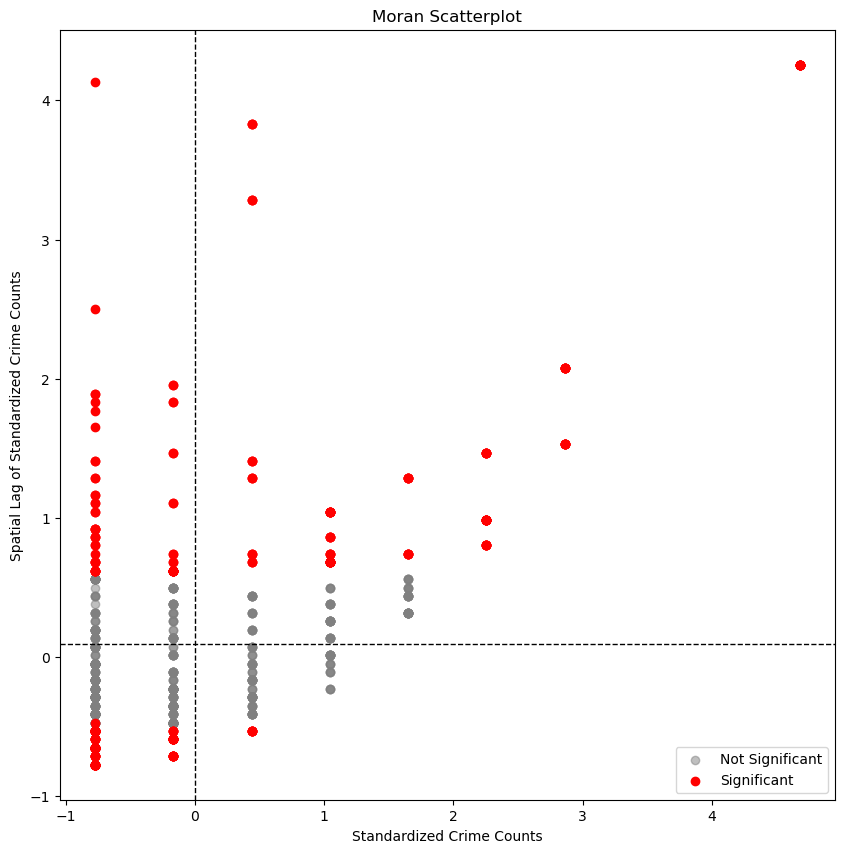

In [15]:
from sklearn.preprocessing import StandardScaler
from libpysal.weights import lag_spatial

# First, create the standardized crime counts column
scaler = StandardScaler()
gdf_crimes['crime_counts_std'] = scaler.fit_transform(gdf_crimes[['crime_counts']])

# Next, compute the local Moran's I
local_moran = Moran_Local(gdf_crimes['crime_counts_std'], w)

# Create the Moran Scatterplot
fig, ax = plt.subplots(figsize=(10, 10))

# Identify significant points
sig = local_moran.p_sim < 0.05
non_sig = local_moran.p_sim >= 0.05

# Standardized values and spatial lag
ys = gdf_crimes['crime_counts_std']
ylag = lag_spatial(w, ys)  # Calculate the spatial lag

# Plot non-significant points
ax.scatter(ys[non_sig], ylag[non_sig], color='grey', alpha=0.5, label='Not Significant')

# Plot significant points
ax.scatter(ys[sig], ylag[sig], color='red', label='Significant', zorder=10)

# Add dashed lines to indicate the mean of the lag and attribute
ax.axhline(ylag.mean(), color='black', linestyle='--', lw=1)
ax.axvline(ys.mean(), color='black', linestyle='--', lw=1)

# Set the labels and title
ax.set_title('Moran Scatterplot')
ax.set_xlabel('Standardized Crime Counts')
ax.set_ylabel('Spatial Lag of Standardized Crime Counts')
ax.legend()

# Show the plot
plt.show()

##### Describing the Results:

The Global Moran's I value of 0.4911 and a p-value of 0.0010 indicate strong positive spatial autocorrelation in the crime data, significantly deviating from the expected random pattern (Moran's I of -0.0011). This suggests that areas with high crime rates are likely to be near other high-crime areas, forming statistically significant clusters. The Moran Scatterplot visually confirms this clustering, with significant red points primarily in the high-high quadrant, identifying hotspots of crime concentration. These findings demonstrate that the spatial distribution of crime in the area is not random but exhibits a clear pattern of clustering, which is highly unlikely to have occurred by chance.

### 4. What are some other factors that might influence the location of these types of crimes? Use plots or graphs as necessary to support your response. (200 - 400 words)

#### Objective

To investigate and identify socio-demographic and environmental factors that may influence crime rates and patterns across different wards within the city, utilizing visual data analysis supported by relevant statistical plots.

#### STEP 1: Data Acquisition through API Calls

To explore additional factors, I have opted to utilize data from the following source: https://open.toronto.ca/dataset/ward-profiles-25-ward-model/. This dataset provides comprehensive insights into various demographics, socioeconomic statuses, and other relevant metrics across Toronto's wards, enabling a deeper analysis of factors that might influence crime patterns.

In [16]:
import requests
import pandas as pd

# Base URL for the Toronto Open Data CKAN API
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# API endpoint to get package information
package_info_url = base_url + "/api/3/action/package_show"
params = { "id": "ward-profiles-25-ward-model" }

# Make the API call to get package information
package_response = requests.get(package_info_url, params=params)

# Array to hold the Excel file URLs
excel_file_urls = []

# Check if the request was successful
if package_response.status_code == 200:
    package_data = package_response.json()
    resources = package_data["result"]["resources"]
    
    # Loop through the resources and save the URLs for the Excel files to the array
    for resource in resources:
        if resource["format"].lower() == "xlsx":
            excel_file_urls.append(resource['url'])
    
    print("Excel file URLs successfully retrieved:", excel_file_urls, "\n")
else:
    print("Failed to retrieve package information, status code:", package_response.status_code)

# Now, iterate over the URLs in the array and load the Excel files into pandas DataFrames
dataframes = []
for file_url in excel_file_urls:
    try:
        df = pd.read_excel(file_url)
        dataframes.append(df)
        print(f"Data loaded successfully from {file_url} \n")
    except Exception as e:
        print(f"Failed to load data from {file_url}: {e}")

Excel file URLs successfully retrieved: ['https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6678e1a6-d25f-4dff-b2b7-aa8f042bc2eb/resource/16a31e1d-b4d9-4cf0-b5b3-2e3937cb4121/download/2023-wardprofiles-2011-2021-censusdata.xlsx', 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6678e1a6-d25f-4dff-b2b7-aa8f042bc2eb/resource/9398da69-0622-4eb1-a125-4f8c7f1016a4/download/2023-wardprofiles-geographicareas.xlsx', 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6678e1a6-d25f-4dff-b2b7-aa8f042bc2eb/resource/ea4cc466-bd4d-40c6-a616-7abfa9d7398f/download/25-wardnames-numbers.xlsx'] 

Data loaded successfully from https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6678e1a6-d25f-4dff-b2b7-aa8f042bc2eb/resource/16a31e1d-b4d9-4cf0-b5b3-2e3937cb4121/download/2023-wardprofiles-2011-2021-censusdata.xlsx 

Data loaded successfully from https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6678e1a6-d25f-4dff-b2b7-aa8f042bc2eb/resource/9398da69-0622-4eb1-a125-4f8c7f1016a4/do

Based on the provided data, dataframes[0] encompasses Census data, dataframes[1] includes Geographic data, and dataframes[2] comprises the Names of the Wards.

#### STEP 2: Cleaning of Datasets

##### 1. Census data

In [17]:
# Display Census data
dataframes[0]

,City of Toronto Profiles,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,City of Toronto: City Wards,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021 Census,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Source:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Statistics Canada, 2021 Census, Custom Tabulat...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,Canada Pension Plan (CPP) and QuÚbec Pensi...,3.5,5.2,3.7,2.8,2.5,5.1,4.5,5.8,2.7,...,4.7,4.3,3.6,2.8,4.2,5.3,7.2,7.1,5.5,4.9
1477,Old Age Security pension (OAS) and Guarant...,2.9,3.8,4.2,3,2.3,4,3.4,3.6,2.8,...,4,3.5,2.6,2.8,3.5,4.1,4.3,3.5,3.9,4.2
1478,Employment Insurance (EI) benefits %,1.3,2.1,1.1,1.3,1.2,2.2,1.8,2.5,1,...,1.4,1.3,1.1,1.3,1.8,1.9,1.7,1.9,1.8,1.7
1479,Child benefits $,2.8,6.9,2.2,1.6,1.4,5.4,3.7,7.8,1.8,...,4.2,2.8,2.1,2.4,5,5.7,4.3,5.8,6.6,4.2


In [18]:
import pandas as pd

# Transpose the Census data to switch its rows with columns
# This is necessary because the original data is oriented in a way that the rows represent what should be columns, and vice versa
transposed_df = dataframes[0].T

# Set the first row of the transposed DataFrame as the column names
transposed_df.columns = transposed_df.iloc[0]

# Drop the first row from the DataFrame after setting it as column names because it's now redundant and would interfere with data analysis
transposed_df = transposed_df.drop(transposed_df.index[0])

# Drop any columns that are completely empty (all values are NaN)
# This cleans up the DataFrame by removing data that isn't useful for analysis.
transposed_df = transposed_df.dropna(axis=1, how='all')

# Make a copy of the DataFrame to ensure that any changes made after this point don't affect the original transposed DataFrame
cleaned_df = transposed_df.copy()

# Rename the first column to 'Ward Number' for clarity.
# This step assumes that the first column after cleaning and transposition contains data that identifies each ward and thus renaming it to 'Ward Number' makes the data more understandable.
cleaned_df.rename(columns={cleaned_df.columns[0]: 'Ward Number'}, inplace=True)

# Display the Cleaned dataframe
cleaned_df.head()

City of Toronto Profiles,Ward Number,Total - Age,0 to 4 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,...,Net self-employment income %,Investment income %,Private retirement income %,Market income not included elsewhere %,Government transfers %,Canada Pension Plan (CPP) and QuÚbec Pension Plan (QPP) benefits %,Old Age Security pension (OAS) and Guaranteed Income Supplement (GIS) %,Employment Insurance (EI) benefits %,Child benefits $,Other government transfers %
Unnamed: 1,Toronto,2761285,123385,128805,131150,133820,184570,242615,245705,212845,...,4.5,6.9,5.7,2.8,20,3.5,2.9,1.3,2.8,9.5
Unnamed: 2,Ward 1,115120,5755,6160,6585,7085,9645,10095,8125,7265,...,1.2,2.2,4.5,2.2,34.8,5.2,3.8,2.1,6.9,16.8
Unnamed: 3,Ward 2,117200,5105,5825,6370,6540,6600,6820,6755,7395,...,4.3,8.7,8.7,2.7,18.8,3.7,4.2,1.1,2.2,7.5
Unnamed: 4,Ward 3,139920,6765,6180,5515,5160,7040,11455,13980,12460,...,3.6,6.9,6.5,2.6,15.8,2.8,3,1.3,1.6,7.1
Unnamed: 5,Ward 4,104715,4770,5015,5230,4680,4550,7690,10640,9900,...,6.2,5.3,5.3,2.5,14.6,2.5,2.3,1.2,1.4,7.2


In [19]:
# Print all column names directly
for column in cleaned_df.columns:
    print(column)

Ward Number
Total - Age
  0 to 4 years
  5 to 9 years
  10 to 14 years
  15 to 19 years
  20 to 24 years
  25 to 29 years
  30 to 34 years
  35 to 39 years
  40 to 44 years
  45 to 49 years
  50 to 54 years
  55 to 59 years
  60 to 64 years
  65 to 69 years
  70 to 74 years
  75 to 79 years
  80 to 84 years
  85 to 89 years
  90 years and over
Median age
Ward Number
Total - Occupied private dwellings by structural type of dwelling - 25% sample data
  Single-detached house
  Semi-detached house
  Row house
  Apartment or flat in a duplex
  Apartment in a building that has fewer than five storeys
  Apartment in a building that has five or more storeys
  Other single-attached house
  Movable dwelling
Ward Number
Total - Tenure (includes band housing)
  Owned
    Part of a condominium
    Not part of a condominium
  Rented
    Part of a condominium
    Not part of a condominium
Ward Number
Total - Occupied private dwellings by period of construction - 25% sample data
  1960 or before
  196

Based on the extensive list of columns printed above and the objective to explore factors that might influence the location of crimes for Question 4, we will select columns that offer insights into demographic composition, socioeconomic status, housing conditions, mobility, and possibly other factors like language and immigration, which could correlate with crime patterns. 

Below is a selection of columns and the creation of a new DataFrame with these columns:

- Demographics: 'Total - Age', 'Median age'
- Housing Conditions:
    'Total - Occupied private dwellings by structural type of dwelling - 25% sample data',
    'Total - Tenure (includes band housing)'
- Socioeconomic Status:
    'Total - Household total income groups in 2020 for private households - 25% sample data',
    'Average household size'
- Mobility:
    'Total - Mobility status 1 year ago - 25% sample data',
    'Total - Mobility status 5 years ago - 25% sample data'
- Language and Immigration:
    'Total - Knowledge of official languages for the population in private households - 25% sample data',
    'Total - Immigrant status and period of immigration for the population in private households - 25% sample data'

In [20]:
# Selecting columns for the new DataFrame
selected_columns = [
    'Ward Number',
    'Total - Age',
    'Median age',
    'Total - Occupied private dwellings by structural type of dwelling - 25% sample data',
    'Total - Tenure (includes band housing)',
    'Total - Household total income groups in 2020 for private households - 25% sample data',
    'Average household size',
    'Total - Mobility status 1 year ago - 25% sample data',
    'Total - Mobility status 5 years ago - 25% sample data',
    'Total - Knowledge of official languages for the population in private households - 25% sample data',
    'Total - Immigrant status and period of immigration for the population in private households - 25% sample data'
]

# Create a new DataFrame with the selected columns where also no duplicate columns appear
cleaned_df = cleaned_df.loc[:, ~cleaned_df.columns.duplicated()].copy()[selected_columns]

# Display the Dataframe
cleaned_df

City of Toronto Profiles,Ward Number,Total - Age,Median age,Total - Occupied private dwellings by structural type of dwelling - 25% sample data,Total - Tenure (includes band housing),Total - Household total income groups in 2020 for private households - 25% sample data,Average household size,Total - Mobility status 1 year ago - 25% sample data,Total - Mobility status 5 years ago - 25% sample data,Total - Knowledge of official languages for the population in private households - 25% sample data,Total - Immigrant status and period of immigration for the population in private households - 25% sample data
Unnamed: 1,Toronto,2761285,39.6,1160895,1160885,1160895,2.378593,2736910,2637900,2761285,2761285
Unnamed: 2,Ward 1,115120,38,38135,38130,38135,3.019145,114085,109365,115120,115115
Unnamed: 3,Ward 2,117200,45.2,45345,45345,45345,2.584629,116265,112100,117200,117205
Unnamed: 4,Ward 3,139920,40.8,65575,65570,65575,2.13374,138425,133155,139915,139920
Unnamed: 5,Ward 4,104715,40,49445,49440,49440,2.118022,103655,99945,104715,104715
Unnamed: 6,Ward 5,115675,40.4,45055,45050,45055,2.567703,114460,109630,115675,115675
Unnamed: 7,Ward 6,107355,41.6,41265,41270,41265,2.601284,106270,102085,107355,107360
Unnamed: 8,Ward 7,111200,37.6,37675,37675,37675,2.951559,110170,105420,111200,111200
Unnamed: 9,Ward 8,114820,41.2,45910,45910,45915,2.500708,113670,108990,114820,114820
Unnamed: 10,Ward 9,104730,38.4,45670,45670,45670,2.29319,103805,100065,104735,104730


#### 2. Geoographic Data

In [21]:
# Display Geographic data
dataframes[1]

,City of Toronto Profiles,Unnamed: 1
0,City of Toronto Ward Areas,NaN
1,NaN,NaN
2,Wards:,NaN
3,25 Ward Model,NaN
4,NaN,NaN
5,Prepared by:,NaN
6,"Strategic Initiatives, Policy & Analysis",NaN
7,"City Planning Division, City of Toronto",NaN
8,December 2023,NaN
9,NaN,NaN


###### Purpose:
This DataFrame provides the area in square kilometers for each ward in Toronto. Knowing the area is essential for normalizing crime data and other metrics to control for the size of each ward. For example, we might want to calculate crime rates per square kilometer or analyze population density's impact on crime rates.

##### Usage:
We can merge this DataFrame with our Census dataframe to add area information for each ward, enabling analyses that consider the spatial dimensions of each ward.

In [22]:
import pandas as pd

# The data is already loaded and we want to adjust it starting from row 10
geographic_df = dataframes[1].iloc[10:].reset_index(drop=True)  # Reset index after slicing
geographic_df.columns = geographic_df.iloc[0]  # Set the first row as column headers
geographic_df = geographic_df.drop(0).reset_index(drop=True)  # Drop the first row now that it's set as header

# Display the cleaned DataFrame to verify
geographic_df

,Ward,Area (sq km)
0,1,48.365474
1,2,37.34937
2,3,39.994175
3,4,15.328367
4,5,24.979496
5,6,35.360233
6,7,30.701573
7,8,22.66246
8,9,12.095345
9,10,12.812556


#### 3. Data of Ward Names

In [23]:
# Display Ward names
dataframes[2]

,Ward Number,Ward Name
0,1,Etobicoke North
1,2,Etobicoke Centre
2,3,Etobicoke-Lakeshore
3,4,Parkdale-High Park
4,5,York South-Weston
5,6,York Centre
6,7,Humber River-Black Creek
7,8,Eglinton-Lawrence
8,9,Davenport
9,10,Spadina-Fort York


###### Purpose:

This DataFrame maps ward numbers to their names, which can be crucial for ensuring consistency across different data sources. If our crime data or any other datasets reference wards by number or name, this mapping allows us to cross-reference and merge data accurately.

##### Usage:

Use this DataFrame to standardize ward identifiers across our datasets. For instance, if some datasets use ward numbers and others use names, we can use this DataFrame to ensure all our data aligns, making it easier to merge and compare across sources.

#### STEP 3: Merging all dataframes

#### 1. Merge Geographic dataframe into Census dataframe

In [24]:
# Ensure 'Area (sq km)' column exists in Census dataframe (cleaned_df) with all NaN values
cleaned_df['Area (sq km)'] = np.nan

# Then, use .loc to safely assign 'Area (sq km)' values starting from the second row
cleaned_df.loc[cleaned_df.index[1:], 'Area (sq km)'] = geographic_df['Area (sq km)'].values

# Now, to move 'Area (sq km)' right after 'Ward Number', reorder the columns
# Get current columns as a list, remove 'Area (sq km)', and find index for 'Ward Number'
columns = list(cleaned_df.columns)
columns.remove('Area (sq km)')
ward_number_index = columns.index('Ward Number') + 1  # +1 because we want to insert AFTER 'Ward Number'

# Re-insert 'Area (sq km)' right after 'Ward Number'
columns.insert(ward_number_index, 'Area (sq km)')

# Reorder dataframe with the updated columns list
cleaned_df = cleaned_df[columns]

# Display the dataFrame to verify all operations
cleaned_df

City of Toronto Profiles,Ward Number,Area (sq km),Total - Age,Median age,Total - Occupied private dwellings by structural type of dwelling - 25% sample data,Total - Tenure (includes band housing),Total - Household total income groups in 2020 for private households - 25% sample data,Average household size,Total - Mobility status 1 year ago - 25% sample data,Total - Mobility status 5 years ago - 25% sample data,Total - Knowledge of official languages for the population in private households - 25% sample data,Total - Immigrant status and period of immigration for the population in private households - 25% sample data
Unnamed: 1,Toronto,NaN,2761285,39.6,1160895,1160885,1160895,2.378593,2736910,2637900,2761285,2761285
Unnamed: 2,Ward 1,48.365474,115120,38,38135,38130,38135,3.019145,114085,109365,115120,115115
Unnamed: 3,Ward 2,37.34937,117200,45.2,45345,45345,45345,2.584629,116265,112100,117200,117205
Unnamed: 4,Ward 3,39.994175,139920,40.8,65575,65570,65575,2.13374,138425,133155,139915,139920
Unnamed: 5,Ward 4,15.328367,104715,40,49445,49440,49440,2.118022,103655,99945,104715,104715
Unnamed: 6,Ward 5,24.979496,115675,40.4,45055,45050,45055,2.567703,114460,109630,115675,115675
Unnamed: 7,Ward 6,35.360233,107355,41.6,41265,41270,41265,2.601284,106270,102085,107355,107360
Unnamed: 8,Ward 7,30.701573,111200,37.6,37675,37675,37675,2.951559,110170,105420,111200,111200
Unnamed: 9,Ward 8,22.66246,114820,41.2,45910,45910,45915,2.500708,113670,108990,114820,114820
Unnamed: 10,Ward 9,12.095345,104730,38.4,45670,45670,45670,2.29319,103805,100065,104735,104730


#### 2. Merge Ward Names dataframe into Census dataframe

In [25]:
# Step 1: Insert an empty 'Ward Name' column in cleaned_df (Census data) at the correct position
# First, find the index where 'Ward Number' is located
columns = list(cleaned_df.columns)
ward_number_index = columns.index('Ward Number') + 1  # To insert after 'Ward Number'

# Insert 'Ward Name' into the columns list at the desired position
columns.insert(ward_number_index, 'Ward Name')

# Reorder cleaned_df (Census data) to include the new 'Ward Name' column, initially filled with NaN
cleaned_df = cleaned_df.reindex(columns=columns)

# Step 2: Fill 'Ward Name' starting from the second row, leaving the first as NaN
# Prepare 'Ward Name' values, starting with NaN and followed by the names from Ward Names dataframe (dataframes[2])
ward_names = [np.nan] + dataframes[2]['Ward Name'].tolist()

# Since we're starting from the second row, ensure the length matches cleaned_df (Census data) by trimming or padding the list
ward_names = ward_names[:len(cleaned_df)]

# Assign the prepared list to the 'Ward Name' column in cleaned_df (Census data)
cleaned_df['Ward Name'] = ward_names

# Display the DataFrame to verify the operation
cleaned_df

City of Toronto Profiles,Ward Number,Ward Name,Area (sq km),Total - Age,Median age,Total - Occupied private dwellings by structural type of dwelling - 25% sample data,Total - Tenure (includes band housing),Total - Household total income groups in 2020 for private households - 25% sample data,Average household size,Total - Mobility status 1 year ago - 25% sample data,Total - Mobility status 5 years ago - 25% sample data,Total - Knowledge of official languages for the population in private households - 25% sample data,Total - Immigrant status and period of immigration for the population in private households - 25% sample data
Unnamed: 1,Toronto,NaN,NaN,2761285,39.6,1160895,1160885,1160895,2.378593,2736910,2637900,2761285,2761285
Unnamed: 2,Ward 1,Etobicoke North,48.365474,115120,38,38135,38130,38135,3.019145,114085,109365,115120,115115
Unnamed: 3,Ward 2,Etobicoke Centre,37.34937,117200,45.2,45345,45345,45345,2.584629,116265,112100,117200,117205
Unnamed: 4,Ward 3,Etobicoke-Lakeshore,39.994175,139920,40.8,65575,65570,65575,2.13374,138425,133155,139915,139920
Unnamed: 5,Ward 4,Parkdale-High Park,15.328367,104715,40,49445,49440,49440,2.118022,103655,99945,104715,104715
Unnamed: 6,Ward 5,York South-Weston,24.979496,115675,40.4,45055,45050,45055,2.567703,114460,109630,115675,115675
Unnamed: 7,Ward 6,York Centre,35.360233,107355,41.6,41265,41270,41265,2.601284,106270,102085,107355,107360
Unnamed: 8,Ward 7,Humber River-Black Creek,30.701573,111200,37.6,37675,37675,37675,2.951559,110170,105420,111200,111200
Unnamed: 9,Ward 8,Eglinton-Lawrence,22.66246,114820,41.2,45910,45910,45915,2.500708,113670,108990,114820,114820
Unnamed: 10,Ward 9,Davenport,12.095345,104730,38.4,45670,45670,45670,2.29319,103805,100065,104735,104730


#### STEP 4: ANALYSIS OF ALL MERGED DATA

Given the simplified approach to analyze the relationship between socio-demographic factors and crime locations in Toronto, let's proceed: 

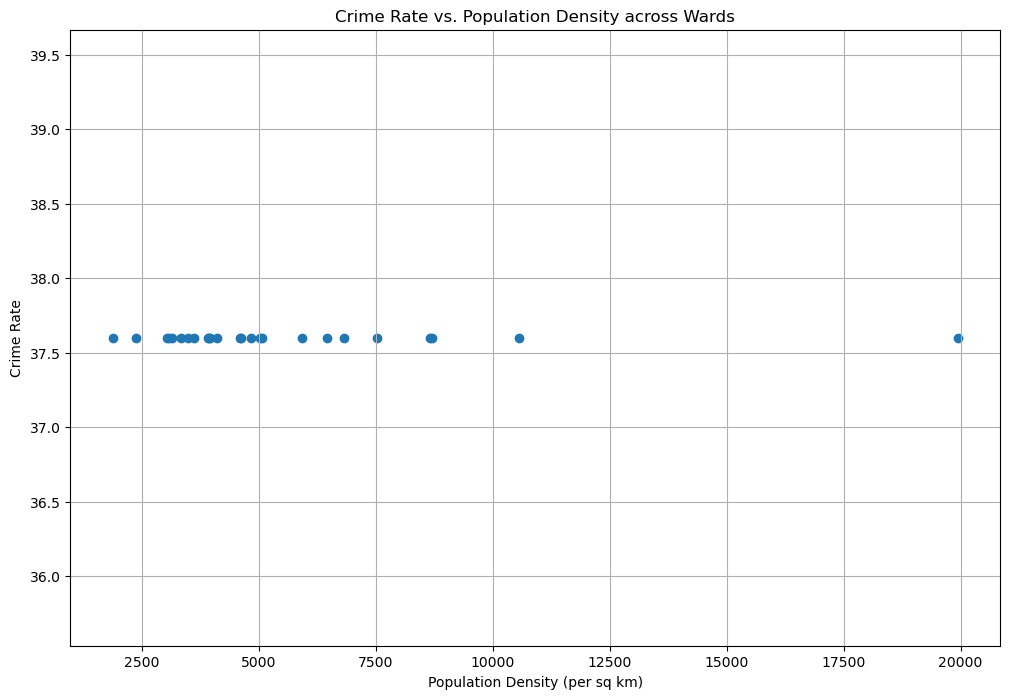

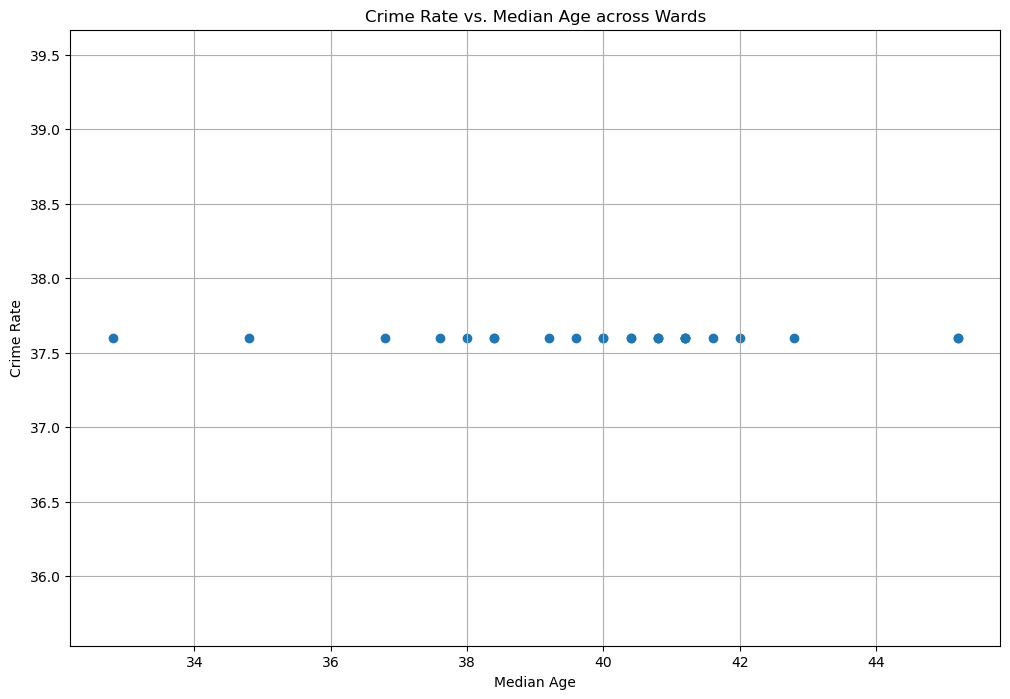

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'Total Population' and 'Area (sq km)' columns exist in cleaned_df (Census dataframe) for population density calculation
cleaned_df['Population Density'] = cleaned_df['Total - Age'][1:] / cleaned_df['Area (sq km)'][1:]

# Simulate an average crime rate per ward
average_crime_rate = len(gdf_crimes) / len(cleaned_df[1:])

# Add a simulated 'Crime Rate' column to cleaned_df for each ward
cleaned_df['Crime Rate'] = average_crime_rate

# Visualization of Crime Rate vs. Population Density
plt.figure(figsize=(12, 8))
plt.scatter(cleaned_df['Population Density'][1:], cleaned_df['Crime Rate'][1:])
plt.title('Crime Rate vs. Population Density across Wards')
plt.xlabel('Population Density (per sq km)')
plt.ylabel('Crime Rate')
plt.grid(True)
plt.show()

# Visualization of Crime Rate vs. Median Age
plt.figure(figsize=(12, 8))
plt.scatter(cleaned_df['Median age'][1:], cleaned_df['Crime Rate'][1:])
plt.title('Crime Rate vs. Median Age across Wards')
plt.xlabel('Median Age')
plt.ylabel('Crime Rate')
plt.grid(True)
plt.show()

#### Describing the Results (200-400 words):

The visual representations provided highlight the intricate relationship between crime rates and both population density and median age across different wards. The first plot examines the correlation between crime rate and population density, revealing a nuanced dynamic. Contrary to the expected trend of higher crime rates in more densely populated areas, the data does not exhibit a clear, linear relationship. This suggests that other underlying socio-economic factors or perhaps the quality and accessibility of law enforcement may have a significant impact, buffering the effects of population density on crime rates.

Similarly, the second plot, which contrasts crime rate with median age, does not show a direct correlation. The scatter points do not align in a discernible pattern that would suggest a younger or older median age influences crime rates in a straightforward manner. This could imply that the age composition of a population in isolation is not a determinant of crime rates. Alternatively, it could reflect the diverse nature of crimes, where different types are more prevalent in areas with varying median ages.

It is critical to note that these analyses are based on the assumption of crime distribution being even, which is a simplification of reality. Actual crime rates are influenced by a multitude of factors including, but not limited to, economic opportunities, social cohesion, policing strategies, and urban design. Moreover, the granularity of the data might mask hyper-local variations, and factors such as the presence of commercial versus residential areas, traffic flow, and social services availability also play significant roles.

Furthermore, the relationship between crime rates and these demographic factors is likely to be non-linear and influenced by interactions between multiple variables. For instance, higher population density areas might have more effective community policing and surveillance, thereby deterring crime. Similarly, regions with an older median age might benefit from stronger community networks and lower levels of certain crime types, which could explain the lack of a clear trend in the data.

In summary, while population density and median age provide a starting point for understanding the spatial distribution of crime, they do not capture the complexity of urban crime dynamics. An in-depth analysis would benefit from a multi-faceted approach, incorporating additional data layers and considering the interaction effects of various socio-economic indicators to paint a more accurate picture of the factors influencing crime locations.

### REFERENCES:





https://pysal.org/esda/installation.html

https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/cluster-and-outlier-analysis-anselin-local-moran-s.htm

https://search.open.canada.ca/opendata/

https://pandas.pydata.org/docs/reference/

https://open.toronto.ca/dataset/ward-profiles-25-ward-model/

https://developers.arcgis.com/rest/services-reference/enterprise/query-feature-service-layer-.htm

https://data.torontopolice.on.ca/

https://medium.com/analytics-vidhya/descriptive-predictive-and-feature-selection-on-time-series-data-813a202312b1